## Text-To-Image Generation via Masked Generative Transformers
1.   **Algorithm** (Muse-Low Res)
2.   **Library** (torch, muse_maskgit_pytorch)
3.   **Result** (High-Quality Text-to-Image Conversion Using Masked Generative Transformers)


> **Installing the Required Libraries**



In [1]:
pip install muse-maskgit-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 11.0 MB/s eta 0:00:00




> **Train VAE**
1. Number of Images = 20
2. Number of Train Steps = 500



In [2]:
import torch
from muse_maskgit_pytorch import VQGanVAE, VQGanVAETrainer

vae = VQGanVAE(
    dim = 256,
    codebook_size = 65536
)

In [3]:
trainer = VQGanVAETrainer(
    vae = vae,
    image_size = 128,
    folder = '/content/drive/MyDrive/Text To Image Generation/Muse-Masked Generative Transformers/images',
    batch_size = 4,
    grad_accum_every = 8,
    num_train_steps = 500
).cuda()

trainer.train()

20 training samples found at /content/drive/MyDrive/Text To Image Generation/Muse-Masked Generative Transformers/images
training with dataset of 19 samples and validating with randomly splitted 1 samples


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 79.8MB/s]


0: vae loss: -0.8058074787259102 - discr loss: 13.656961381435394
0: saving to results
0: saving model to results
1: vae loss: 0.059762582182884216 - discr loss: 11.450533747673035
2: vae loss: -32.93194913864136 - discr loss: 10.54336667060852
3: vae loss: -41.756399631500244 - discr loss: 9.519816040992737
4: vae loss: -17.400368571281433 - discr loss: 7.910000026226044
5: vae loss: -1.1958508118987083 - discr loss: 5.170484155416489
6: vae loss: 2.2068831771612167 - discr loss: 3.460640013217926
7: vae loss: 23.294641733169556 - discr loss: 4.692479342222214
8: vae loss: 7.602936208248138 - discr loss: 5.686972796916962
9: vae loss: -3.4937654435634613 - discr loss: 6.874189376831055
10: vae loss: -2.6750772148370743 - discr loss: 5.7667118310928345
11: vae loss: -0.7390181794762611 - discr loss: 5.125859498977661
12: vae loss: -1.9088083356618881 - discr loss: 5.585997939109802
13: vae loss: -3.674971789121628 - discr loss: 5.948085010051727
14: vae loss: -4.436391144990921 - discr



> **Save VAE**



In [4]:
torch.save(vae.state_dict(), '/content/drive/MyDrive/Text To Image Generation/Muse-Masked Generative Transformers/vae_model.pt')



> **Pass the Trained VQGanVAE and a Transformer to MaskGit**



In [5]:
import torch
from muse_maskgit_pytorch import VQGanVAE, MaskGit, MaskGitTransformer

# first instantiate your vae

vae = VQGanVAE(
    dim = 256,
    codebook_size = 65536
).cuda()

vae.load('/content/drive/MyDrive/Text To Image Generation/Muse-Masked Generative Transformers/vae_model.pt')

# then you plug the vae and transformer into your MaskGit as so

# (1) create your transformer / attention network

transformer = MaskGitTransformer(
    num_tokens = 65536,       # must be same as codebook size above
    seq_len = 256,            # must be equivalent to fmap_size ** 2 in vae
    dim = 512,                # model dimension
    depth = 8,                # depth
    dim_head = 64,            # attention head dimension
    heads = 8,                # attention heads,
    ff_mult = 4,              # feedforward expansion factor
    t5_name = 't5-small',     # name of your T5
)

# (2) pass your trained VAE and the base transformer to MaskGit

base_maskgit = MaskGit(
    vae = vae,                 # vqgan vae
    transformer = transformer, # transformer
    image_size = 256,          # image size
    cond_drop_prob = 0.25,     # conditional dropout, for classifier free guidance
).cuda()


/usr/local/lib/python3.10/dist-packages/muse_maskgit_pytorch/vqgan_vae.py:419: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(str(path))


Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

In [6]:
# ready your training text and images
import pandas as pd
from PIL import Image
import torch
import torchvision.transforms as transforms
import os

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

excel_file = '/content/drive/MyDrive/Text To Image Generation/Muse-Masked Generative Transformers/Image Number-Text-Second.xlsx'
data = pd.read_excel(excel_file)

images = []
texts = data['text'].tolist()

for image_file in data['image_filename']:
    image = Image.open(f'/content/drive/MyDrive/Text To Image Generation/Muse-Masked Generative Transformers/images - Second/{image_file}').convert("RGB")
    image = transform(image)
    images.append(image)

images = torch.stack(images).cuda()


# feed it into your maskgit instance, with return_loss set to True

loss = base_maskgit(
    images,
    texts = texts
)

loss.backward()

# do this for a long time on much data
# then...



model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]



> **Generating New Images with Muse**


In [20]:
images = base_maskgit.generate(texts = [
    'A red bus',
    'A parked motorcycle',
    'Children standing near a boat'
], cond_scale = 3.) # conditioning scale for classifier free guidance

images.shape # (3, 3, 256, 256)

  0%|          | 0/18 [00:00<?, ?it/s]

torch.Size([3, 3, 256, 256])

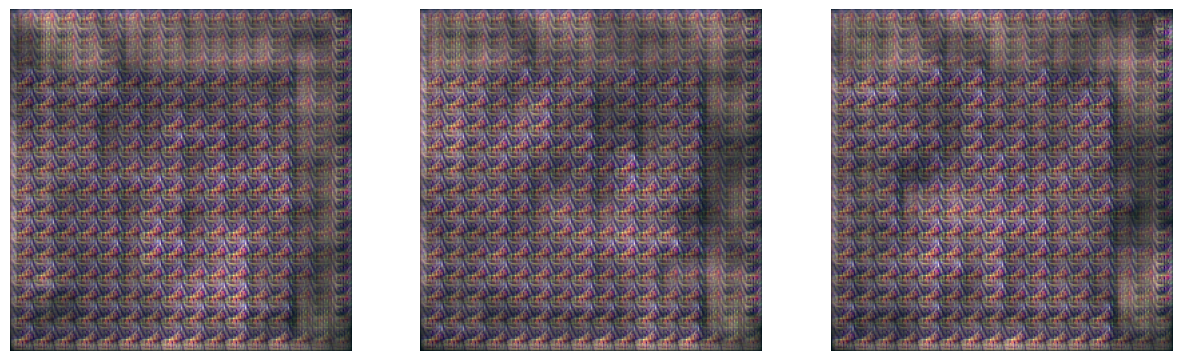

In [21]:
import matplotlib.pyplot as plt
import numpy as np

images = images.cpu().numpy() if images.is_cuda else images.numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    img = np.clip(images[i].transpose(1, 2, 0), 0, 1)

    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()
